# Parsing measurement data

In [1]:
import math

def lmap(f,x):
    return list(map(f,x))

def process_raw_decay_data(id, startTime = -1, threshold = 0.7, floating_avg = True):
    peaks = []

    # startTime == -1 => auto cutoff
    auto_cutoff = False
    if(startTime == -1):
        auto_cutoff = True
        startTime = 0

    with open(f"./inputs/Spinner_{id}_decay_rate.csv") as inp:
        lines = inp.read().split("\n")

        startInd = 1
        while (float(lines[startInd].split(",")[0]) < startTime): startInd += 1
        
        hitPeak = False
        startPeak = 0
        endPeak = 0
        for i in range(startInd, len(lines)-1):
            row = lines[i].split(",")

            if (float(row[1]) >= threshold and not hitPeak):
                hitPeak = True
                startPeak = float(row[0])


            if (float(row[1]) < threshold and hitPeak):
                hitPeak = False
                endPeak = float(row[0])

                peaks.append((endPeak+startPeak)/2)                

    results = {}
    interval = 1
    step = 0.1
    curTime = startTime
    x = 0
    while x < len(peaks):
        if (peaks[x] > curTime+interval):
            curTime += step
            x = 0
        elif (peaks[x] > curTime and peaks[x] < curTime+interval):
            if (not curTime in results): results[curTime] = 1
            else: results[curTime] += 1
            
        x += 1

    cutoff_val = math.inf
    if(auto_cutoff):
        cutoff_val = 0

    if(floating_avg):   
        with open(f"./outputs/Spinner_{id}_decay_rate_PROCESSED_FLOATING_AVERAGE.csv", 'w') as res:
            res.write("t, peaks/s, omega \n")
            for x in range(4, len(results.keys())):
                flAverage = 0
                for y in range(5):
                    flAverage += results[list(results.keys())[x-y]]
                flAverage = flAverage/5

                if(auto_cutoff):
                    if(flAverage > cutoff_val):
                        cutoff_val = flAverage

                if(flAverage < cutoff_val):
                    res.write(str(round(list(results.keys())[x-y], 1)) + "," + str(flAverage) + "," + str(flAverage*2*math.pi/3) + "\n")

        return f"./outputs/Spinner_{id}_decay_rate_PROCESSED_FLOATING_AVERAGE.csv"
    else:
        with open(f"./outputs/Spinner_{id}_decay_rate_PROCESSED.csv", 'w') as res:
            res.write("t, peaks/s \n")
            for key in results.keys():
                res.write(str(round(key, 1)) + "," + str(results[key]) + "\n")
        
        return f"./outputs/Spinner_{id}_decay_rate_PROCESSED.csv"


In [2]:
processed_paths = []
# for i in range(1,8,1):
for i in range(1,2,1):
    out_path = process_raw_decay_data(i, -1, 0.7)
    processed_paths.append(out_path)

# Fitting for $\alpha$, $\beta$, $\gamma$, $c_1$

$$
\omega(t) = - \sqrt{\frac{\alpha}{\gamma}} \tan{(\sqrt{\alpha\gamma}(t-c_1))}
$$

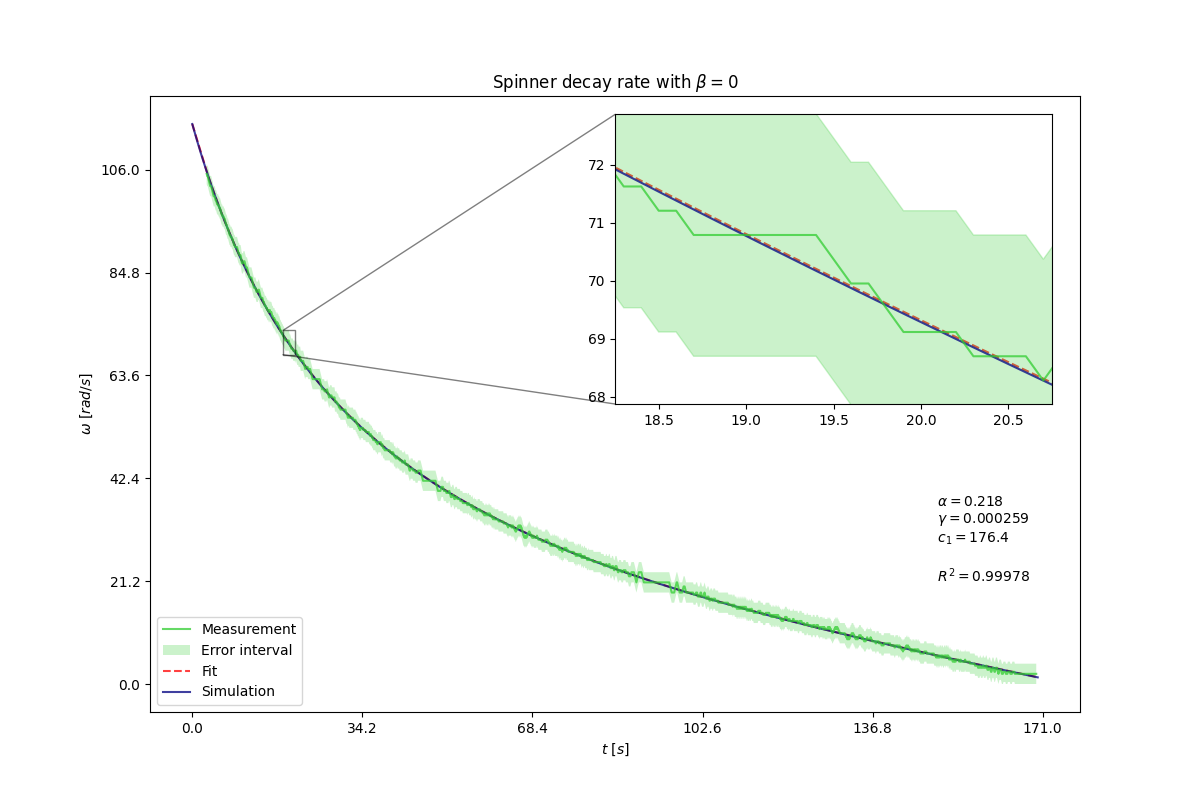

In [3]:
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

%matplotlib widget

alphas = []
gammas = []
cs = []
omega_0s = []
R_squares = []

for i in range(len(processed_paths)):
    path = processed_paths[i]
    fig, ax = plt.subplots(figsize=(12, 8))
    axins = None
    
    with open(path, "r") as read:
        data = read.readlines()[1:]
        data = lmap(lambda row: row.rstrip().split(","), data)

        xdata = lmap(lambda row: float(row[0]), data)
        ydata = lmap(lambda row: float(row[2]), data)

        omega_0s.append(ydata[0])

        def ω(time, alpha, gamma, c_1):
            return [
                - math.sqrt(alpha / gamma)
                * math.tan(math.sqrt(alpha * gamma) * (t - c_1))
                for t in time
            ]
            
        [alpha, gamma, c], pcov = opt.curve_fit(
            ω,
            xdata,
            ydata,
            bounds=(
                [0, 0, 0],  # min
                [1, 0.01, math.inf],  # max
            ),
            p0=[0.21, 0.00025, 170],
            max_nfev=10000
        )
        perr = np.sqrt(np.diag(pcov))

        # calc R^2
        residuals = np.array(ydata) - np.array(ω(xdata, *[alpha, gamma, c]))
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((np.array(ydata) - np.mean(ydata))**2)
        r_squared = 1 - (ss_res / ss_tot)

        alphas.append(alpha)
        gammas.append(gamma)
        cs.append(c)
        R_squares.append(r_squared)

        # INSET
        x1 = xdata[round(len(xdata)/10)] - 1.25
        x2 = x1 + 2.5
        y1 = ydata[round(len(ydata)/10)] - 2.5 
        y2 = ydata[round(len(ydata)/10)] + 2.5
        axins = ax.inset_axes(
            [0.5, 0.5, 0.47, 0.47],
            xlim=(x1, x2), ylim=(y1, y2))
        
        # Measurement
        plt.plot(xdata, ydata, label="Measurement", color="limegreen", zorder=2, alpha=0.75)
        axins.plot(xdata, ydata, label="Measurement", color="limegreen", zorder=2, alpha=0.75)
        
        # ERROR
        plt.fill(
            xdata + xdata[::-1], 
            lmap(lambda y: y+2/3 * math.pi, ydata) +
            lmap(lambda y: y-2/3 * math.pi, ydata)[::-1], 
            label="Error interval",
            color="limegreen",
            edgecolor="none",
            alpha = 0.25
        )
        axins.fill(
            xdata + xdata[::-1], 
            lmap(lambda y: y+2/3 * math.pi, ydata) +
            lmap(lambda y: y-2/3 * math.pi, ydata)[::-1], 
            color="limegreen",
            alpha = 0.25
        )
        
        plt.xlabel("$t$ $[s]$")
        plt.ylabel("$\omega$ $[rad/s]$")

        plt.xticks(np.linspace(0, round(max(xdata)) + 1, 6))
        plt.yticks(np.linspace(0, round(max(ydata)) + 1, 6))

        plt.title(f"Spinner decay rate with $\\beta = 0$")
        plt.text(max(xdata) * 0.8, max(ydata) * 0.2, 
                f"""
                $\\alpha={alpha:.3f}$
                $\\gamma={gamma:.6f}$
                $c_1={c:.1f}$
                
                $R^2={r_squared:.5f}$""")

        # FIT
        # print(ω([0], alpha, gamma, c))
        plt.plot([0, *xdata], ω([0, *xdata], alpha, gamma, c), color="red", linestyle="--", label="Fit", zorder=0, alpha=0.75)
        axins.plot([0, *xdata], ω([0, *xdata], alpha, gamma, c), color="red", linestyle="--", label="Fit", zorder=0, alpha=0.75)
    
    # SIMULATION
    try:
        with open(f"./sim/sim_spinner{i+1}.csv") as read:
            data = read.readlines()[1:]
            data = lmap(lambda row: row.rstrip().split(","), data)

            xdata = lmap(lambda row: float(row[0]), data)
            ydata = lmap(lambda row: float(row[1]), data)
            
            plt.plot(xdata, ydata, label="Simulation", color="navy", linestyle="-", zorder=1, alpha=0.75)
            axins.plot(xdata, ydata, label="Simulation", color="navy", linestyle="-", zorder=1, alpha=0.75)
    except Exception as e:
        print(e)
        pass

    ax.indicate_inset_zoom(axins, edgecolor="black")
        
    plt.legend(loc="lower left")
    
# plt.savefig("spinner_decay.png", format="png", dpi=1500)

# $c_1$ in relation to $\alpha$ and $\gamma$ in our measurements

Averages:
α=0.21793020357622753
γ=0.00025868896588917433
c1=176.39319790487139
R^2=0.9997828510217578


Text(0, 0.5, 'c_1')

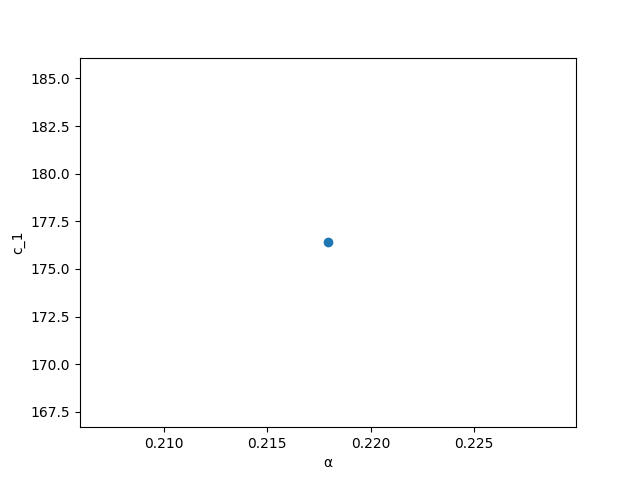

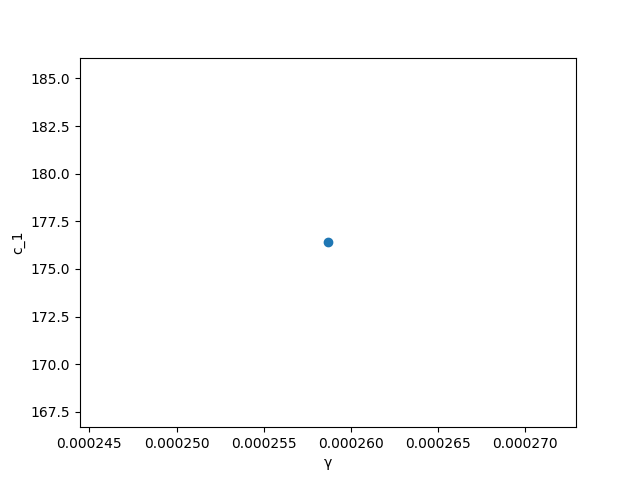

In [4]:
print("Averages:")
print(f"α={np.average(alphas)}")
print(f"γ={np.average(gammas)}")
print(f"c1={np.average(cs)}")
print(f"R^2={np.average(R_squares)}")

plt.figure()
plt.scatter(alphas, cs)

plt.xlabel("α")
plt.ylabel("c_1")

plt.figure()
plt.scatter(gammas, cs)
plt.xlabel("γ")
plt.ylabel("c_1")


# 3D plot of the theoretical $c_1$ in relation $(\alpha, \gamma, \omega_0)$
### (dafuq am i even doing anymore)

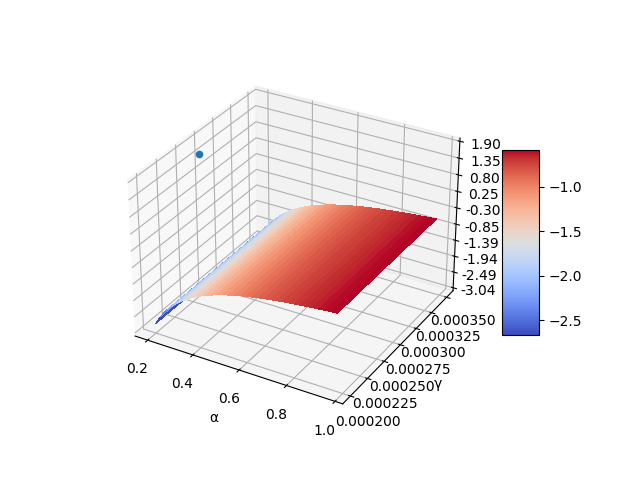

In [5]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
A = np.arange(0.2, 1, 0.025)
G = np.arange(0.0002, 0.0004, 0.00005)
A, G = np.meshgrid(A, G)

omega_0 = 3.14
Z = -np.arctan(np.sqrt(G/A * omega_0))/(omega_0*np.sqrt(A*G))

# Plot the surface.
surf = ax.plot_surface(A, G, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.scatter(
    alphas,
    gammas,
    np.divide(cs, omega_0s)
)

ax.set_xlabel("α")
ax.set_ylabel("γ")
ax.set_zlabel("c_1/ω_0")

plt.show()

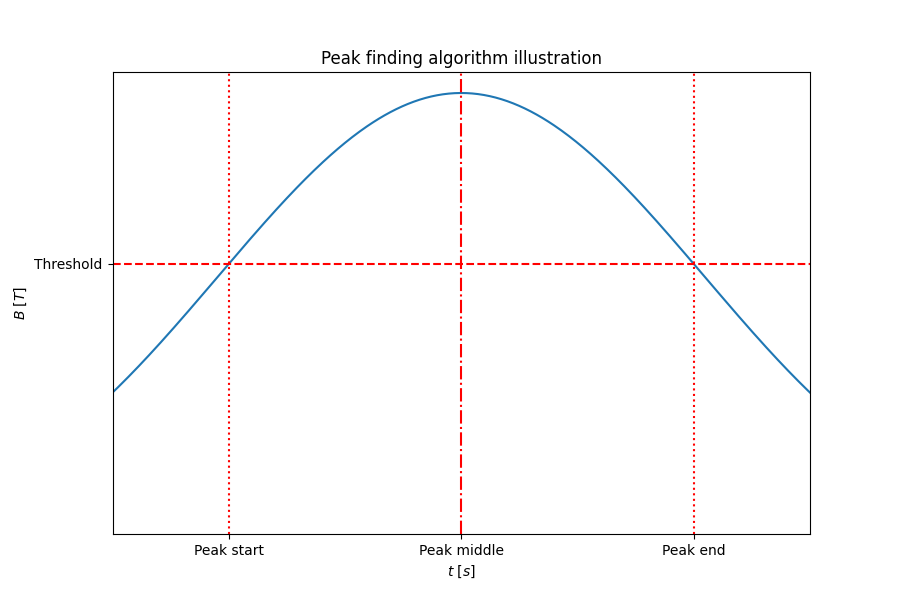

In [6]:
plt.figure(figsize=(9, 6))

plt.plot(
    np.linspace(0,math.pi, 1000),
    np.sin(np.linspace(0,math.pi, 1000))**4
)

plt.xlim(math.pi/2 - 0.75, math.pi/2 + 0.75)

plt.xticks(
    [math.pi/2 - 0.5, math.pi/2, math.pi/2 + 0.5],
    ["Peak start", "Peak middle", "Peak end"]
)
plt.yticks(np.sin([math.pi/2 - 0.5])**4, ["Threshold"])

plt.axvline(math.pi/2 - 0.5, color = "red", linestyle=":")
plt.axvline(math.pi/2 + 0.5, color = "red", linestyle=":")

plt.axvline(math.pi/2, color = "red", linestyle="-.")

plt.axhline(np.sin([math.pi/2 - 0.5])**4, color = "red", linestyle="--")

plt.xlabel("$t$ $[s]$")
plt.ylabel("$B$ $[T]$")
plt.title("Peak finding algorithm illustration")
plt.savefig("peak_find_alg_drawing", dpi=1500)